In [2]:
import skrf as rf
import numpy as np
# pyright: reportCallIssue=false

# Extracción de mediciónes
Para hacer las mediciónes físicas se usó un VNA de 2 puertos Rohde-Schwarz, ZNC3-2Port calibrado en un rango de frecuencias de $0.5$ a $1.5$ GHz.
Como el divisor de Wilkinson tiene 3 puertos, se reconstruye la matriz de parámetros S a través de 3 mediciónes hechas por separado.

La correspondencia puerto VNA -> puerto Wilkinson es:

| Archivo | Puerto VNA | Puerto Dispositivo |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

Finalmente tenemos otro archivo 4.s2p, el cual tiene el through entre los dos cables sin carga en el medio para ver el ripple inherente al instrumento / cables

Primero cargamos los cuatro archivos de mediciónes

In [3]:
m1 = rf.Network('mediciones/1.s2p')
m2 = rf.Network('mediciones/2.s2p')
m3 = rf.Network('mediciones/3.s2p')
m4 = rf.Network('mediciones/4.s2p')

Luego hacemos una red de tres puertos correspondiente al divisor de Wilkinson llamada `willkinson`

In [4]:
#Extraigo las frecuencias del primer archivo
freq = m1.frequency
#Genero matriz de ceros para inicializar red vacia
s_mat = np.zeros((len(freq), 3, 3), dtype=complex)
#Genero red vacia
wilkinson = rf.Network(frequency=freq, s=s_mat, z0=50, name='Wilkinson 3-port')

La notación para referirse a un parámetro S es `wilkinson.s[frec, Sa, Sb]`. Para operar sobre todas las frecuencias simplemente se trabaja en modo rango completo usando `wilkinson.s[: ,Sa, Sb]`. El indexado inicia en 0, no en 1, con lo cual para referirse, por ejemplo, al parámetro $S_{21}$ en todo el espectro de frecuencias disponibles se hace `wilkinson.s[:, 1, 0]`

Ahora vamos a mapear todos los parámetros almacenados en los archivos .s2p (cada uno correspondiente a una red de dos puertos especificada en tabla) a la red de tres puertos `wilkinson` correspondiente a nuestro divisor de potencia.

Para las mediciónes de transmisión, hay una sola opción en cada caso con lo cual simplemente se mapea del archivo s2p a la variable

In [5]:
# Archivo 1.s2p (m1): VNA p1 -> Dispositivo p2 | VNA p2 -> Dispositivo p3
wilkinson.s[:, 2, 1] = m1.s[:, 1, 0]  # S21 de m1 -> S32 del dispositivo (transmisión p2->p3)
wilkinson.s[:, 1, 2] = m1.s[:, 0, 1]  # S12 de m1 -> S23 del dispositivo (transmisión p3->p2)

# Archivo 2.s2p (m2): VNA p1 -> Dispositivo p1 | VNA p2 -> Dispositivo p2
wilkinson.s[:, 1, 0] = m2.s[:, 1, 0]  # S21 de m2 -> S21 del dispositivo (transmisión p1->p2)
wilkinson.s[:, 0, 1] = m2.s[:, 0, 1]  # S12 de m2 -> S12 del dispositivo (transmisión p2->p1)

# Archivo 3.s2p (m3): VNA p1 -> Dispositivo p1 | VNA p2 -> Dispositivo p3
wilkinson.s[:, 2, 0] = m3.s[:, 1, 0]  # S21 de m3 -> S31 del dispositivo (transmisión p1->p3)
wilkinson.s[:, 0, 2] = m3.s[:, 0, 1]  # S12 de m3 -> S13 del dispositivo (transmisión p3->p1)

Ahora las reflexiónes. Hay 2 mediciónes de cada una ya que cada puerto se usó en dos archivos diferentes. Al no tener información sobre cuál es más confiable, hacemos un promedio simple de todas las reflexiónes

In [6]:
# Reflexión S11 (promedio de m2 y m3)
aux = (m2.s[:, 0, 0] + m3.s[:, 0, 0]) / 2  # Promedio de S11 de m2 y S11 de m3
wilkinson.s[:, 0, 0] = aux  # S11 del dispositivo

# Reflexión S22 (promedio de m1 y m2)
aux = (m1.s[:, 0, 0] + m2.s[:, 1, 1]) / 2  # S11 de m1 -> S22, S22 de m2 -> S22
wilkinson.s[:, 1, 1] = aux  # S22 del dispositivo

# Reflexión S33 (promedio de m1 y m3)
aux = (m1.s[:, 1, 1] + m3.s[:, 1, 1]) / 2  # S22 de m1 -> S33, S22 de m3 -> S33
wilkinson.s[:, 2, 2] = aux  # S33 del dispositivo

Ahora el bloque `wilkinson` tiene la matriz completa de parámetros S extraidos mediante mediciónes.

# Ploteos
Ploteamos transferencia, adaptación y aislación en tres gráficos separados desde función `plot_s_parameters` hecha a parte para simplificar y estandarizar ploteos

Tenemos tres redes:

La primera red es una simulación ideal hecha en ADS:

<img src="img/schematic.jpg" width="600">

A esa red la importo y la llamo `wilkinson_ideal`

Luego está la simulación hecha en ADS en la que se simuló el bloque físico con parámetros del sustrato y resistencias reales. A esa red la llamo `wilkinson_simulada`

<img src="img/simulado.jpg" width="600">

Y finalmente las mediciónes reales extraidas del VNA con las que venimos trabajando hasta ahora, a las cuales tenombramos `wilkionson_real`

<img src="img/terminado.jpg" width="600">

Como las simulaciónes estan exportadas como parámetros s3p, es decir red de 3 puertos, no hace falta hacerles mucho procesamiento


In [7]:
# Se preparan las tres redes
wilkinson_ideal = rf.Network('simulaciones/ideal.s3p')
wilkinson_simulado = rf.Network('simulaciones/simulado.s3p')
wilkinson_real = wilkinson

In [8]:
from importlib import reload
import plotear  # Importa el módulo (no la función directamente)

In [9]:
reload(plotear)  # Recarga el módulo desde disco
from plotear import plot_s_parameters  # Vuelve a importar la función actualizada

## Función de ploteos
Función guardada en un archivo a parte llamado `plotear.py` que plotea con un formato estandarizado para este caso. Las lineas verticales sólidas azules están fijadas en $1\text{GHz}$ mientras que las líneas punteadas son los picos (máximo o mínimo segun corresponda) de cada curva. El valor en $\text{GHz}$ de cada línea punteada está en la leyenda

## Primero se plotea el ideal

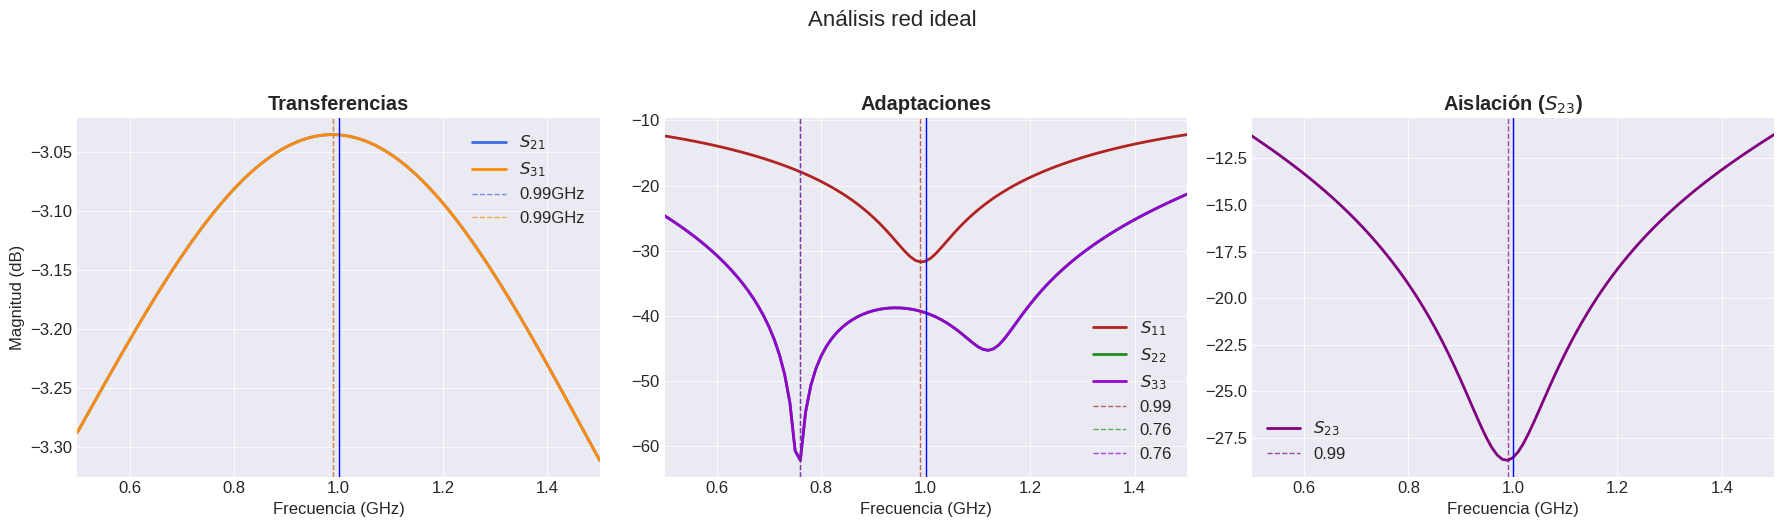

In [10]:
plot_s_parameters(wilkinson_ideal, 'Análisis red ideal', save_fig=True, autoscales=True)

Luego se plotean los parámetros desde la simulación

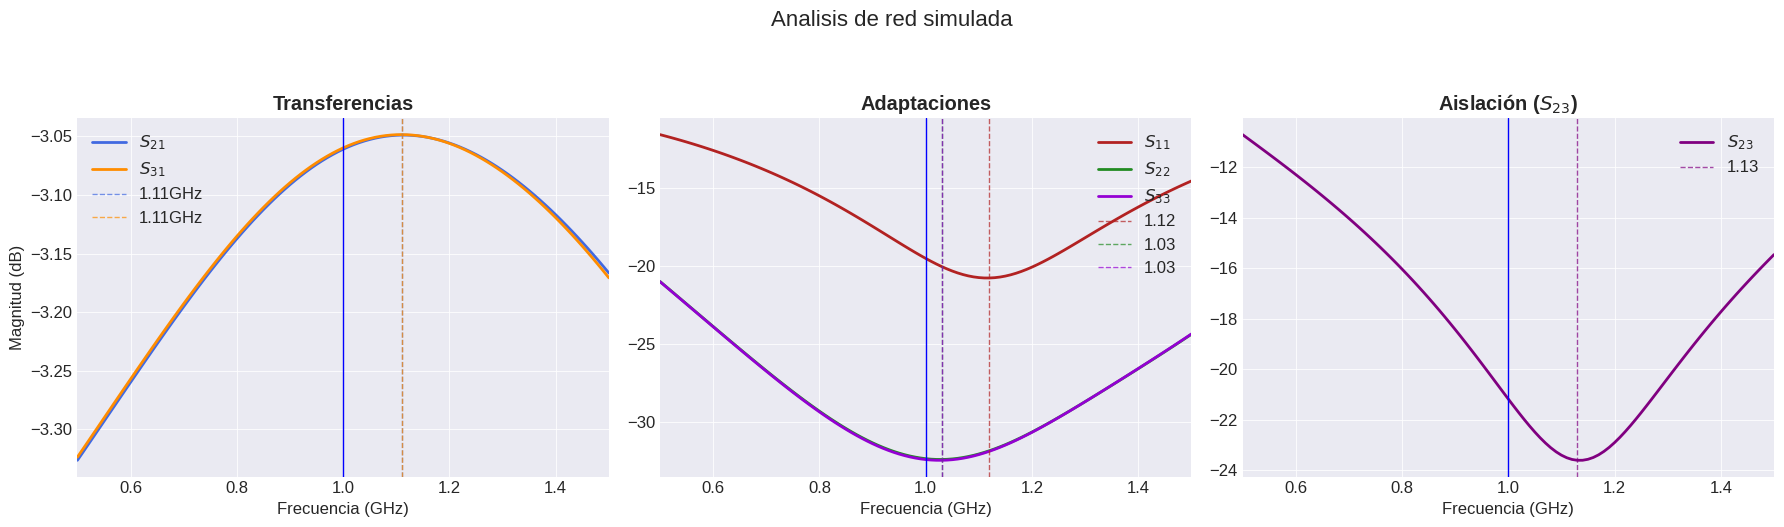

In [11]:
plot_s_parameters(wilkinson_simulado, 'Analisis de red simulada', save_fig=True, autoscales=True)

Y finalmente desde los parámetros medidos

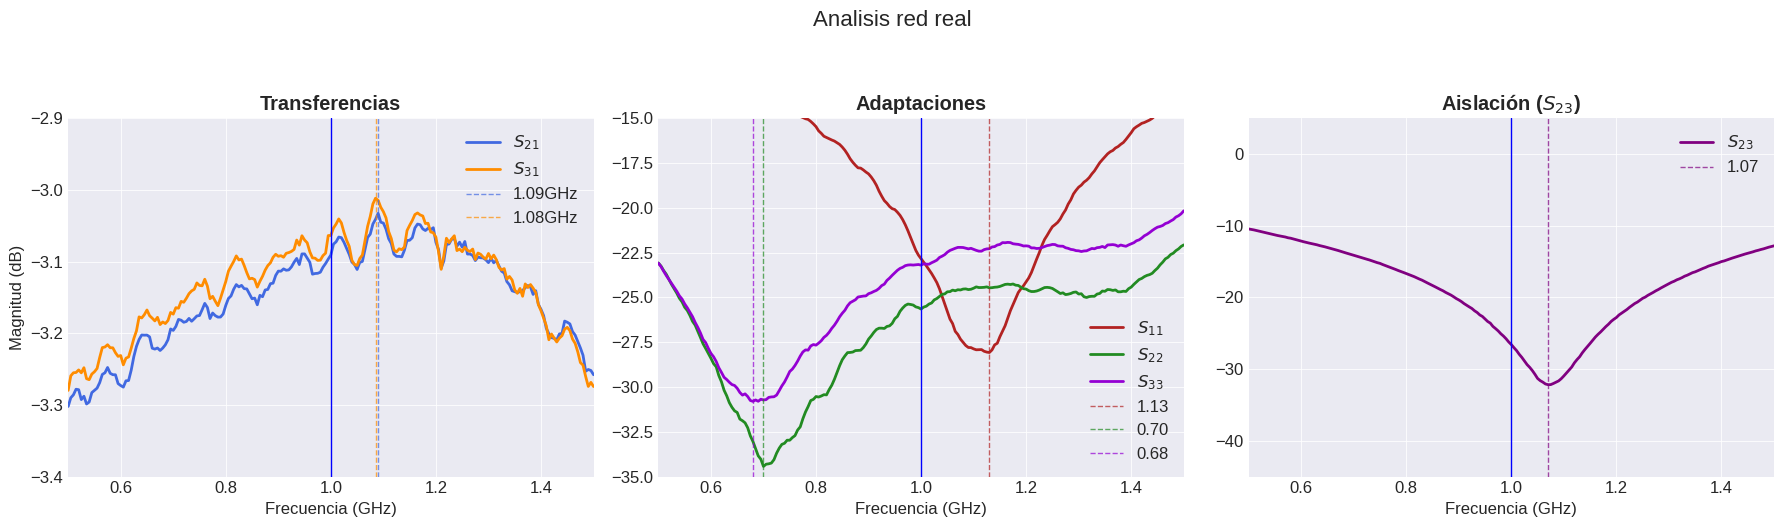

In [12]:
plot_s_parameters(wilkinson_real, 'Analisis red real', save_fig=True, autoscales=False)

A parte del marcado ripple, se puede ver que las tendencias se mantienen en cuando a los picos al lado del desfasaje

# Corrección de error de instrumento
Capturamos también los  parámetros `.2sp` de una conexión directa entre los cables para ver el ripple de nuestro setup

In [13]:
through = rf.Network(frequency = m4.frequency, s = m4.s, z0=50, name='Through')

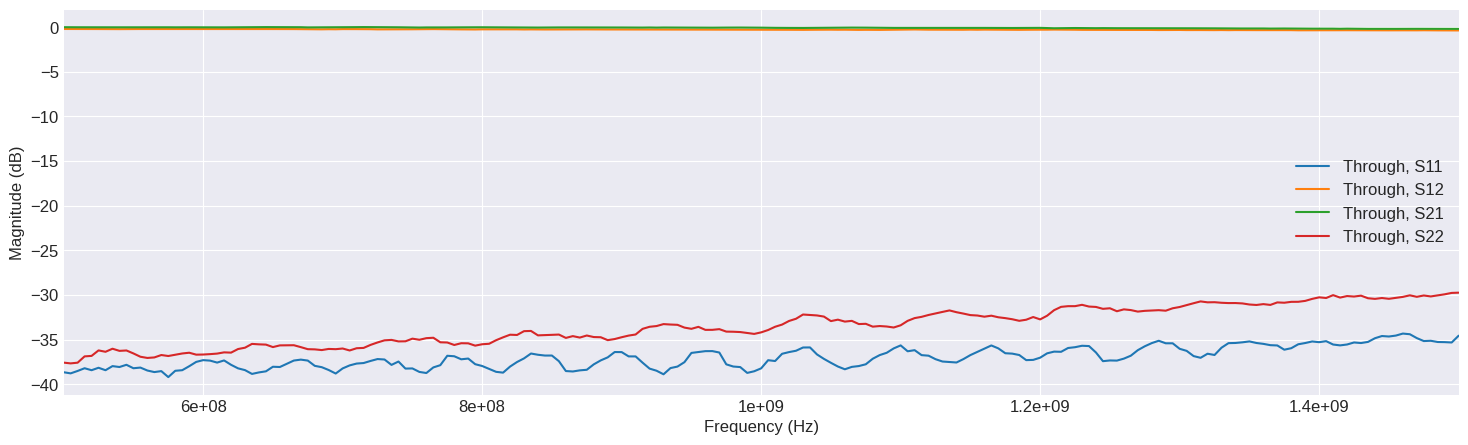

In [14]:
through.plot_s_db()

Hay una enorme diferencia entre las transferencias y los rebotes. Concentrandome en las transferencias

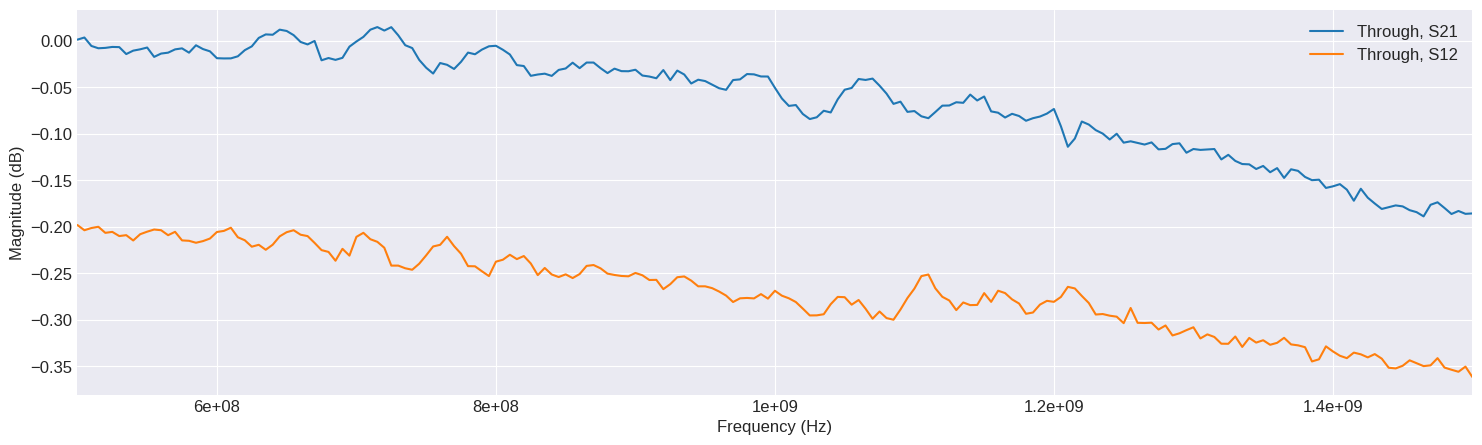

In [15]:
through.plot_s_db(m=1, n=0)
through.plot_s_db(m=0, n=1)

Ajá, acá sí, sin embargo las amplitudes se ven de 0.05 maso. Poco.

Para hacer una nueva red con la corrección aplicada voy a necesitar la correspondiencia de los puertos del VNA originales y los puertos de la red `wilkinson`.<br>
Por ejemplo: La transferencia $S_{31}$ de la red de Wilkinson se corresponde la transferencia $S_{21}$ del archivo `3.s2p`. Entonces, necesitamos hacer $S_{31}(\text{Wilkinson}) \cdot S_{21}^{-1}(\text{VNA})$, es decir, la transfewrencia de la red armada a partir de las mediciónes del dispositivo por el inverso de la transferencia medida en los cables. Las reflexiónes están promediadas; en el caso de $S_{22}$ la re-calculo usando solamente $S_{11}$ de `2.s2p` ya que está medida de dos puertos del VNA distintos. Las otras dos reflexiónes son consistentes. Acá a no errarle.

## Tabla de archivos original

| Archivo | Puerto VNA | Puerto Dispositivo |
| ------- | ---------- | ------------------ |
| 1.s2p       | 1          | 2                  |
| 1.s2p       | 2          | 3                  |
| 2.s2p       | 1          | 1                  |
| 2.s2p       | 2          | 2                  |
| 3.s2p       | 1          | 1                  |
| 3.s2p       | 2          | 3                  |

## Correspondencia en corrección

| Wilkinson | Correccion
| --------- | ---------------
| $S_{11}$  | $S_{11}$   |
| $S_{22}$  | $S_{11}$   |
| $S_{33}$  | $S_{22}$   |
| $S_{21}$  | $S_{21}$   |
| $S_{31}$  | $S_{21}$   |
| $S_{23}$  | $S_{12}$   |
| $S_{32}$  | $S_{21}$   |

Invertimos la matriz del through para aplicar las correcciónes

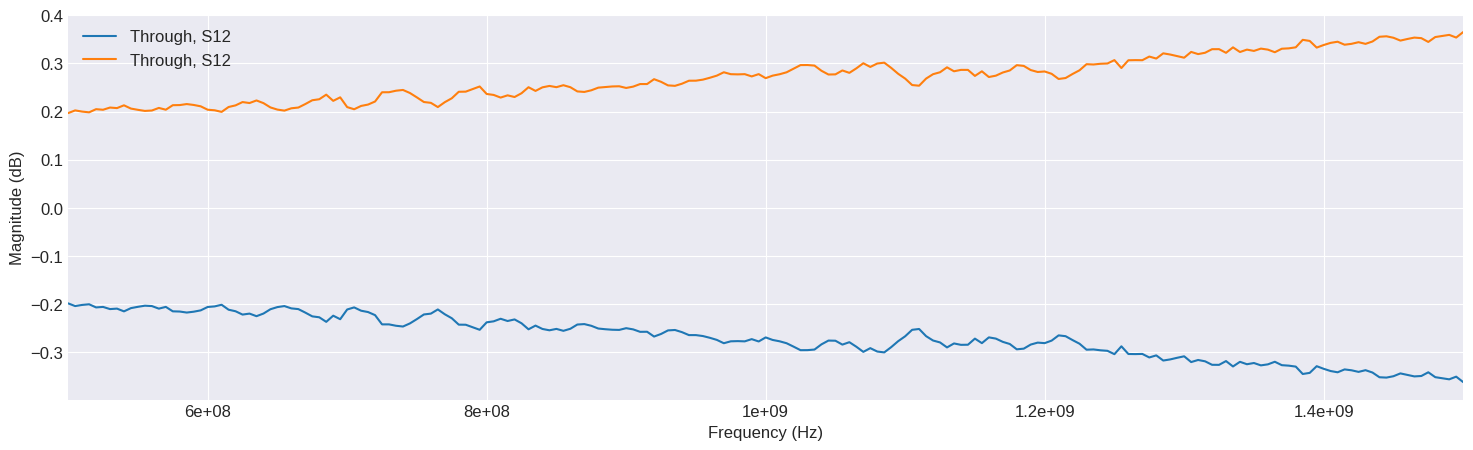

In [16]:
through.plot_s_db(0, 1)
through.inv.plot_s_db(0, 1)

In [17]:
correccion = through.inv

In [18]:
#Re calculo S11
wilkinson.s[:, 0, 0] = m2.s[:, 0, 0]

In [19]:
wilkinson_fix = wilkinson.copy()

In [20]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1] * correccion.s[:, 0, 0]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2] * correccion.s[:, 1, 1]
wilkinson_fix.s[:, 1, 0] = wilkinson.s[:, 1, 0] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 2, 1] = wilkinson.s[:, 2, 1] * correccion.s[:, 1, 0]
wilkinson_fix.s[:, 1, 2] = wilkinson.s[:, 1, 2] * correccion.s[:, 0, 1]

Taraaann a ver los ploteos corregidos

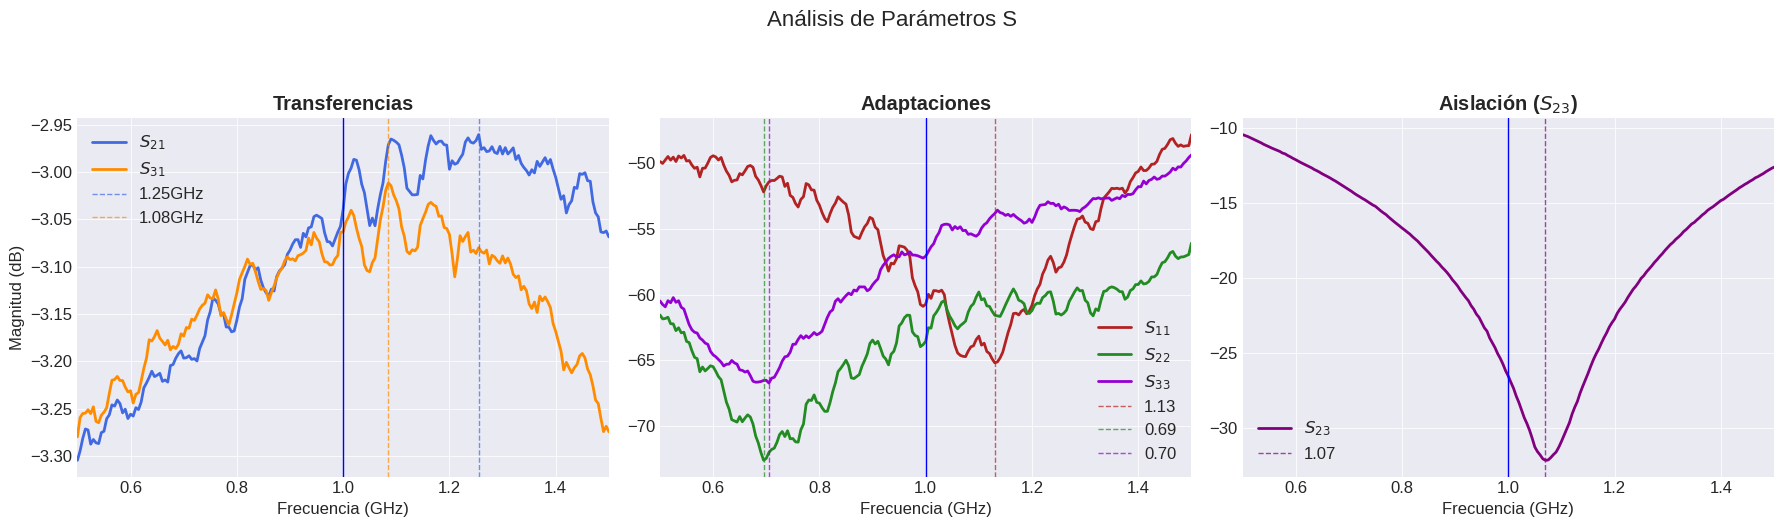

In [21]:
plot_s_parameters(wilkinson_fix, autoscales=True)

Las adaptaciónes están exageradas ya que se están sumando los dB de la adaptación original más los de la adaptación del trough (que no da cero) así que las dejo fuera del calculo. Revierto la red corregida para volver las reflexiónes a sus valores originales

In [22]:
wilkinson_fix.s[:, 0, 0] = wilkinson.s[:, 0, 0]
wilkinson_fix.s[:, 1, 1] = wilkinson.s[:, 1, 1]
wilkinson_fix.s[:, 2, 2] = wilkinson.s[:, 2, 2]

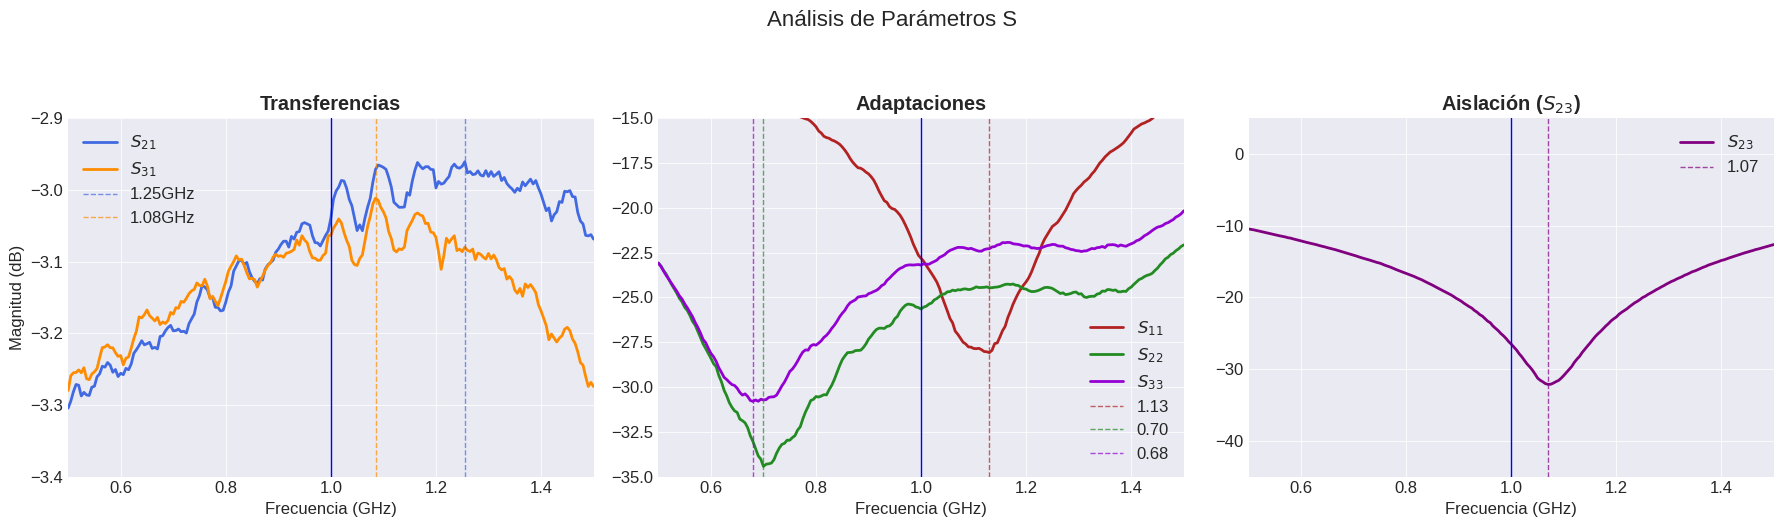

In [23]:
plot_s_parameters(wilkinson_fix, autoscales=False)

A ver contra el no corregido

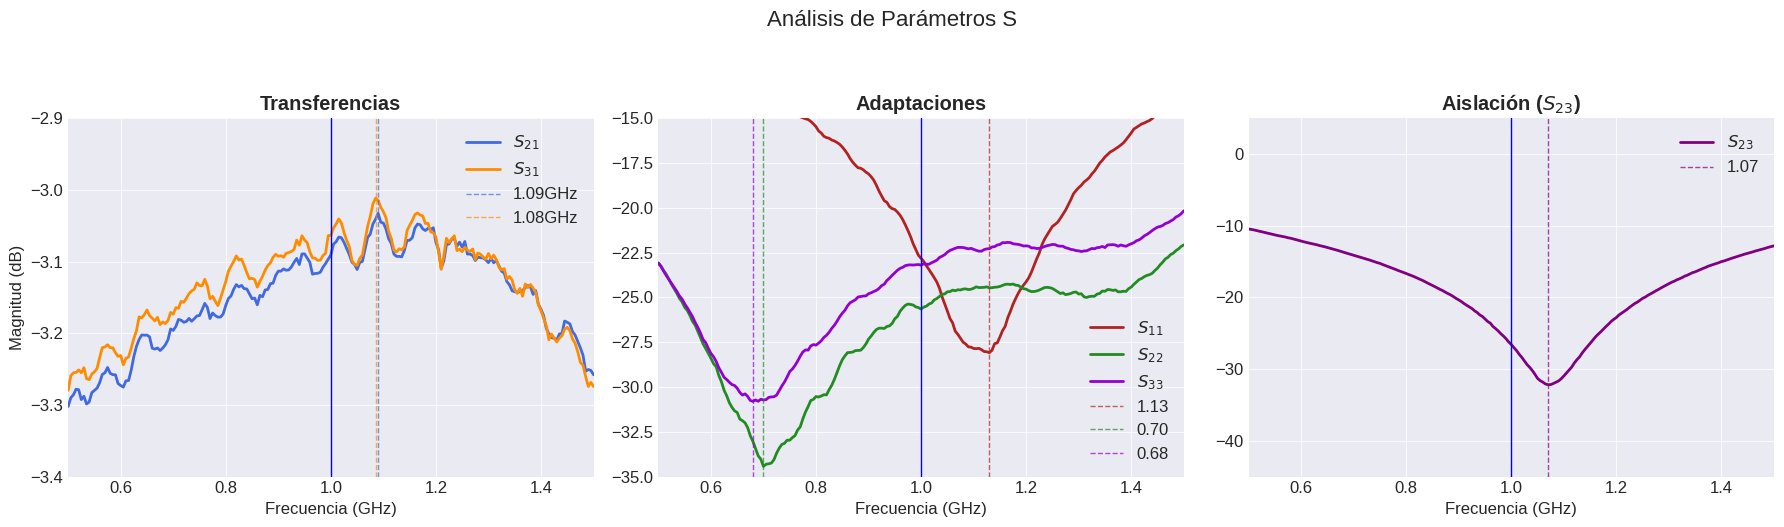

In [24]:
plot_s_parameters(wilkinson_real)

En este caso, el $S_{21}$ mejora bastante en cuanto al ancho de banda pero el ripple no se solucióna